In [1]:
%run PVModel_functions.ipynb

In [2]:
%run PVsystem_filterfunction_jack-may.ipynb

In [3]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import seaborn as sns
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

mod_names = 'LG', 'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar'#, 'Jinko'
mettablename =  'dbo.SNLA_Met_DataOut'

In [4]:
results=[]

In [5]:
for mod_name in mod_names:
    
    
   #Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
    mod_info = pd.read_excel('module_coefficients.xlsx')
    mod_info.index = mod_info['Manufacturer']
    del mod_info['Manufacturer']
    #defines the specific module given the previous user input and module coefficients file
    module = mod_info[mod_name]
    systablename = module['table_name']
    start = module['start']
    end = module['end']
    #year='2020'
    
    #Import sys & met databases & merge into one df
    df = sys_met_data(mettablename, systablename, start, end)
    #df, df_meta = meta_col(df)
    #df, df_meta = add_missing_time_steps(df, df_meta, freq='T',save=False)
    
    #Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
    sdf = calc_sol_data(df.index, module['latitude'], module['longitude'], module['tilt'], df['Pressure_mBar_Avg'])
    edf = calc_env_data(module['tilt'], module ['altitude'], module['surface_azimuth'], sdf['azimuth'], sdf['apparent_zenith'], 
               df['Direct_Wm2_Avg'], df['Global_Wm2_Avg'], df['Diffuse_Wm2_Avg'], sdf['dni_extra'], model = 'haydavies')
    edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(edf['airmass'], edf['pressure'])
    
    #Solar Elevation Filter
    sol_elev_mask = simple_filter(sdf, 'apparent_elevation', lower=15, upper=90, apply=False)
    df = df.where(sol_elev_mask, np.nan)
    
    #Calculate effective irradiance and cell temperature
    sapm_par = sapm_param(edf['poa_global'], edf['poa_direct'], edf['poa_diffuse'], df.Temp_C_Avg, df.WS_ms_Mean, 
                   edf['am_abs'], edf['aoi'], module)

    sapm_tcell = sapm_par['tcell'].to_frame()
    eff_irr  = sapm_par['eff_irr'].to_frame()
    temp_irr = pd.merge(sapm_tcell,eff_irr, how = 'inner', left_index=True, right_index=True)
    df = df.merge(temp_irr, how='inner', left_index=True, right_index=True)
    df = df[~df.index.duplicated(keep='first')]
    
    #Filter out pole shading for Can275 and HanQPlus in 2020
    shade_list = ['Can270', 'HanQPlus']
    if mod_name in shade_list:
        shade_start = '2020-10-06 00:00:00-07:00'
        shade_end = '2020-11-02 00:00:00-07:00'
        shask = (df.index > shade_start) & (df.index <= shade_end)
        df = df.loc[~shask]
    
    #Filter and Mask Data 
    
    #Apply physical Filters
    df = simple_filter(df, 'eff_irr', lower=50, upper=1200, apply=True)
    df = simple_filter(df, 'tcell', lower=-40, upper=85, apply=True)
    
    ##### Filter out the data points with a certain ratio of current to irradiance
    string_is ='str_1_i', 'str_2_i', 'str_3_i', 'str_4_i'
    ratio_names = 'ratio str_1_i to eff_irr', 'ratio str_2_i to eff_irr', 'ratio str_3_i to eff_irr', 'ratio str_4_i to eff_irr'
    for string_i in string_is:
        df['ratio' + ' ' + string_i + ' ' 'to eff_irr'] = df[module[string_i]]/df['eff_irr'] 
    for ratio_name in ratio_names:
        df = simple_filter(df, ratio_name, lower=module['ratio_lower'], upper=module['ratio_upper'], apply=True)    
    
   #Generate a results dataframe and add measured values
    str_1 = meas_val(df[module['str_1_v']],df[module['str_1_i']])
    str_2 = meas_val(df[module['str_2_v']],df[module['str_2_i']])
    str_3 = meas_val(df[module['str_3_v']],df[module['str_3_i']])
    str_4 = meas_val(df[module['str_4_v']],df[module['str_4_i']])
    
    #Calcualte SAPM results and add to df
    dc = sapm(df['eff_irr'], df['tcell'], module)
    sapm_results = sapm_p(dc['v_mp'], dc['i_mp'], module['str_len']).to_frame()
    sapm_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    sapm_results['Str_1'] = str_1
    sapm_results['Str_2'] = str_2
    sapm_results['Str_3'] = str_3
    sapm_results['Str_4'] = str_4
    sapm_results['Time'] = sapm_results.index
    sapm_results['Year'] = sapm_results.index.year
    sapm_results['Model Name'] = 'SAPM'
    sapm_results['System'] = mod_name
    results.append(sapm_results)
    
    
    #Calculate PVWatts results and add to df
    pvw_results = (pvwatts(POA_eff = df['eff_irr'], cell_temp = df['tcell'], 
                             stc_mod_p = module['Power'], Gpmp = module['Gpmp'],str_len = module['str_len'],
                                                 temp_ref=25.0 )).to_frame()
    pvw_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    pvw_results['Str_1'] = str_1
    pvw_results['Str_2'] = str_2
    pvw_results['Str_3'] = str_3
    pvw_results['Str_4'] = str_4
    pvw_results['Time'] = pvw_results.index
    pvw_results['Year'] = pvw_results.index.year
    pvw_results['Model Name'] = 'PVW'
    pvw_results['System'] = mod_name
    results.append(pvw_results)
    
   #Calculate CEC results and add to df
    cec_param = pvlib.pvsystem.calcparams_cec( df['eff_irr'], df['tcell'], module['alpha_sc'], 
                                          module['a_ref'], module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], 
                                          module['R_s'], module['Adjust'], module['Cells_in_Series'])
    cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
    cec_results = sdm(cec_p['p_mp'], module['str_len']).to_frame()
    cec_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    cec_results['Str_1'] = str_1
    cec_results['Str_2'] = str_2
    cec_results['Str_3'] = str_3
    cec_results['Str_4'] = str_4
    cec_results['Time'] = cec_results.index
    cec_results['Year'] = cec_results.index.year
    cec_results['Model Name'] = 'CEC'
    cec_results['System'] = mod_name
    results.append(cec_results)
    
   #Calculate Desoto results and add to df
    ds_param = pvlib.pvsystem.calcparams_desoto(df['eff_irr'], df['tcell'], module['alpha_sc'],
                                            module['a_ref'],module['I_L_ref'], module['I_o_ref'], 
                                            module['R_sh_ref'], module['R_s'])
    ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
    des_results = sdm(ds_p['p_mp'], module['str_len']).to_frame()
    des_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    des_results['Str_1'] = str_1
    des_results['Str_2'] = str_2
    des_results['Str_3'] = str_3
    des_results['Str_4'] = str_4
    des_results['Time'] = des_results.index
    des_results['Year'] = des_results.index.year
    des_results['Model Name'] = 'DES'
    des_results['System'] = mod_name
    results.append(des_results)
    
   #Calculte PVSystem results and add to df
    pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['eff_irr'],df['tcell'], module['alpha_sc'], 
                                             module['gamma_ref'],module['mu_gamma'], module['I_L_ref'], module['I_o_ref'],
                                             module['R_sh_ref'], module['R_sh_0'], module['R_s'],  module['Cells_in_Series'])
    pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4], method = 'newton')
    pvs_results = sdm(pvs_p['p_mp'], module['str_len']).to_frame()
    pvs_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    pvs_results['Str_1'] = str_1
    pvs_results['Str_2'] = str_2
    pvs_results['Str_3'] = str_3
    pvs_results['Str_4'] = str_4
    pvs_results['Time'] = pvs_results.index
    pvs_results['Year'] = pvs_results.index.year
    pvs_results['Model Name'] = 'PVS'
    pvs_results['System'] = mod_name
    results.append(pvs_results)
    
    
    #Import matrix of measurement data
    measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
    matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
    matrix.columns = ['temperature', 'irradiance', 'p_mp']
    # calculate efficiency from power
    matrix = matrix.eval('eta = p_mp / irradiance')
    eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
    matrix.eta /= eta_stc.values
    # just keep the columns that are needed
    matrix = matrix[['irradiance', 'temperature', 'eta']]
    
    
   #Calculate ADR results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,adr)
    adr_eff = adr(df['eff_irr'], df['tcell'], *popt)
    adr_results = ((df['eff_irr']/1000) * (adr_eff) * (module['Power']) *12).to_frame()
    adr_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    adr_results['Str_1'] = str_1
    adr_results['Str_2'] = str_2
    adr_results['Str_3'] = str_3
    adr_results['Str_4'] = str_4
    adr_results['Time'] = adr_results.index
    adr_results['Year'] = adr_results.index.year
    adr_results['Model Name'] = 'ADR'
    adr_results['System'] = mod_name
    results.append(adr_results)
    
    
   #Calculate Heydenreich results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,heydenreich)
    hey_eff = heydenreich(df['eff_irr'], df['tcell'], *popt)
    hey_results = ((df['eff_irr']/1000) * (hey_eff) * (module['Power']) *12).to_frame()
    hey_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    hey_results['Str_1'] = str_1
    hey_results['Str_2'] = str_2
    hey_results['Str_3'] = str_3
    hey_results['Str_4'] = str_4
    hey_results['Time'] = hey_results.index
    hey_results['Year'] = hey_results.index.year
    hey_results['Model Name'] = 'HEY'
    hey_results['System'] = mod_name
    results.append(hey_results)
            
    
    #Calculate MotherPV results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,motherpv)
    mother_eff = motherpv(df['eff_irr'], df['tcell'], *popt)
    mot_results = ((df['eff_irr']/1000) * (mother_eff) * (module['Power']) * 12).to_frame()
    mot_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    mot_results['Str_1'] = str_1
    mot_results['Str_2'] = str_2
    mot_results['Str_3'] = str_3
    mot_results['Str_4'] = str_4
    mot_results['Time'] = mot_results.index
    mot_results['Year'] = mot_results.index.year
    mot_results['Model Name'] = 'MOT'
    mot_results['System'] = mod_name
    results.append(mot_results)
    
    
   #Calculate PVGIS results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,pvgis)
    pvgis_eff = pvgis(df['eff_irr'], df['tcell'], *popt)
    pvg_results = ((df['eff_irr']/1000) * (pvgis_eff) * (module['Power']) *12).to_frame()
    pvg_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    pvg_results['Str_1'] = str_1
    pvg_results['Str_2'] = str_2
    pvg_results['Str_3'] = str_3
    pvg_results['Str_4'] = str_4
    pvg_results['Time'] = pvg_results.index
    pvg_results['Year'] = pvg_results.index.year
    pvg_results['Model Name'] = 'PVG'
    pvg_results['System'] = mod_name
    results.append(pvg_results)
    
    
    #Calculate MPM5 results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm5)
    mpm5_eff = mpm5(df['eff_irr'], df['tcell'], *popt)
    mpm5_results = ((df['eff_irr']/1000) * (mpm5_eff) * (module['Power']) *12).to_frame()
    mpm5_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    mpm5_results['Str_1'] = str_1
    mpm5_results['Str_2'] = str_2
    mpm5_results['Str_3'] = str_3
    mpm5_results['Str_4'] = str_4
    mpm5_results['Time'] = mpm5_results.index
    mpm5_results['Year'] = mpm5_results.index.year
    mpm5_results['Model Name'] = 'MPM5'
    mpm5_results['System'] = mod_name
    results.append(mpm5_results)
    
    
     #Calculate MPM6 results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm6)
    mpm6_eff = mpm6(df['eff_irr'], df['tcell'], *popt)
    mpm6_results = ((df['eff_irr']/1000) * (mpm6_eff) * (module['Power']) *12).to_frame()
    mpm6_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    mpm6_results['Str_1'] = str_1
    mpm6_results['Str_2'] = str_2
    mpm6_results['Str_3'] = str_3
    mpm6_results['Str_4'] = str_4
    mpm6_results['Time'] = mpm6_results.index
    mpm6_results['Year'] = mpm6_results.index.year
    mpm6_results['Model Name'] = 'MPM6'
    mpm6_results['System'] = mod_name
    results.append(mpm6_results)
    
   #Calculate Bilinear results and add to df
    interpolator = fit_bilinear(**matrix)
    bilinear_eff = bilinear(df['eff_irr'], df['tcell'], interpolator)
    bil_results = ((df['eff_irr']/1000) * (bilinear_eff) * (module['Power']) * 12).to_frame()
    bil_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    bil_results['Str_1'] = str_1
    bil_results['Str_2'] = str_2
    bil_results['Str_3'] = str_3
    bil_results['Str_4'] = str_4
    bil_results['Time'] = bil_results.index
    bil_results['Year'] = bil_results.index.year
    bil_results['Model Name'] = 'BIL'
    bil_results['System'] = mod_name
    results.append(bil_results)
    
    print(mod_name)
    

LG
Panasonic
Can270
Can275
HanQPlus
HanQPeak
MissionSolar


In [6]:
#Filters results based on solar elevation
meta = pd.concat(results, ignore_index=True)
    
    
strings = ['Str_1','Str_2','Str_3','Str_4']
for string in strings:
    meta['Diff ' + string] = (meta['Modeled Power'] - meta[string])
meta['MBE'] = (meta['Diff Str_1'] + meta['Diff Str_2'] + meta['Diff Str_3'] + meta['Diff Str_4'])/4
#for string in strings:
 #    meta['Abs%Diff ' + string] = 100* abs((meta['Modeled Power'] - meta[string])/(meta[string]))
#meta['MAPE %'] = ((meta.iloc[:,[9,10,11,12]].mean(axis=1)))
    
#meta.to_csv(mod_name + '_meta.csv')

In [7]:
meta

,Modeled Power,Str_1,Str_2,Str_3,Str_4,Time,Year,Model Name,System,Diff Str_1,Diff Str_2,Diff Str_3,Diff Str_4,MBE
0,NaN,NaN,NaN,NaN,NaN,2018-05-24 00:00:00-07:00,2018,SAPM,LG,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2018-05-24 00:01:00-07:00,2018,SAPM,LG,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,2018-05-24 00:02:00-07:00,2018,SAPM,LG,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,2018-05-24 00:03:00-07:00,2018,SAPM,LG,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2018-05-24 00:04:00-07:00,2018,SAPM,LG,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129515431,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:56:00-07:00,2021,BIL,MissionSolar,NaN,NaN,NaN,NaN,NaN
129515432,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:57:00-07:00,2021,BIL,MissionSolar,NaN,NaN,NaN,NaN,NaN
129515433,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:58:00-07:00,2021,BIL,MissionSolar,NaN,NaN,NaN,NaN,NaN
129515434,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:59:00-07:00,2021,BIL,MissionSolar,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'MAPE % MissionSolar')

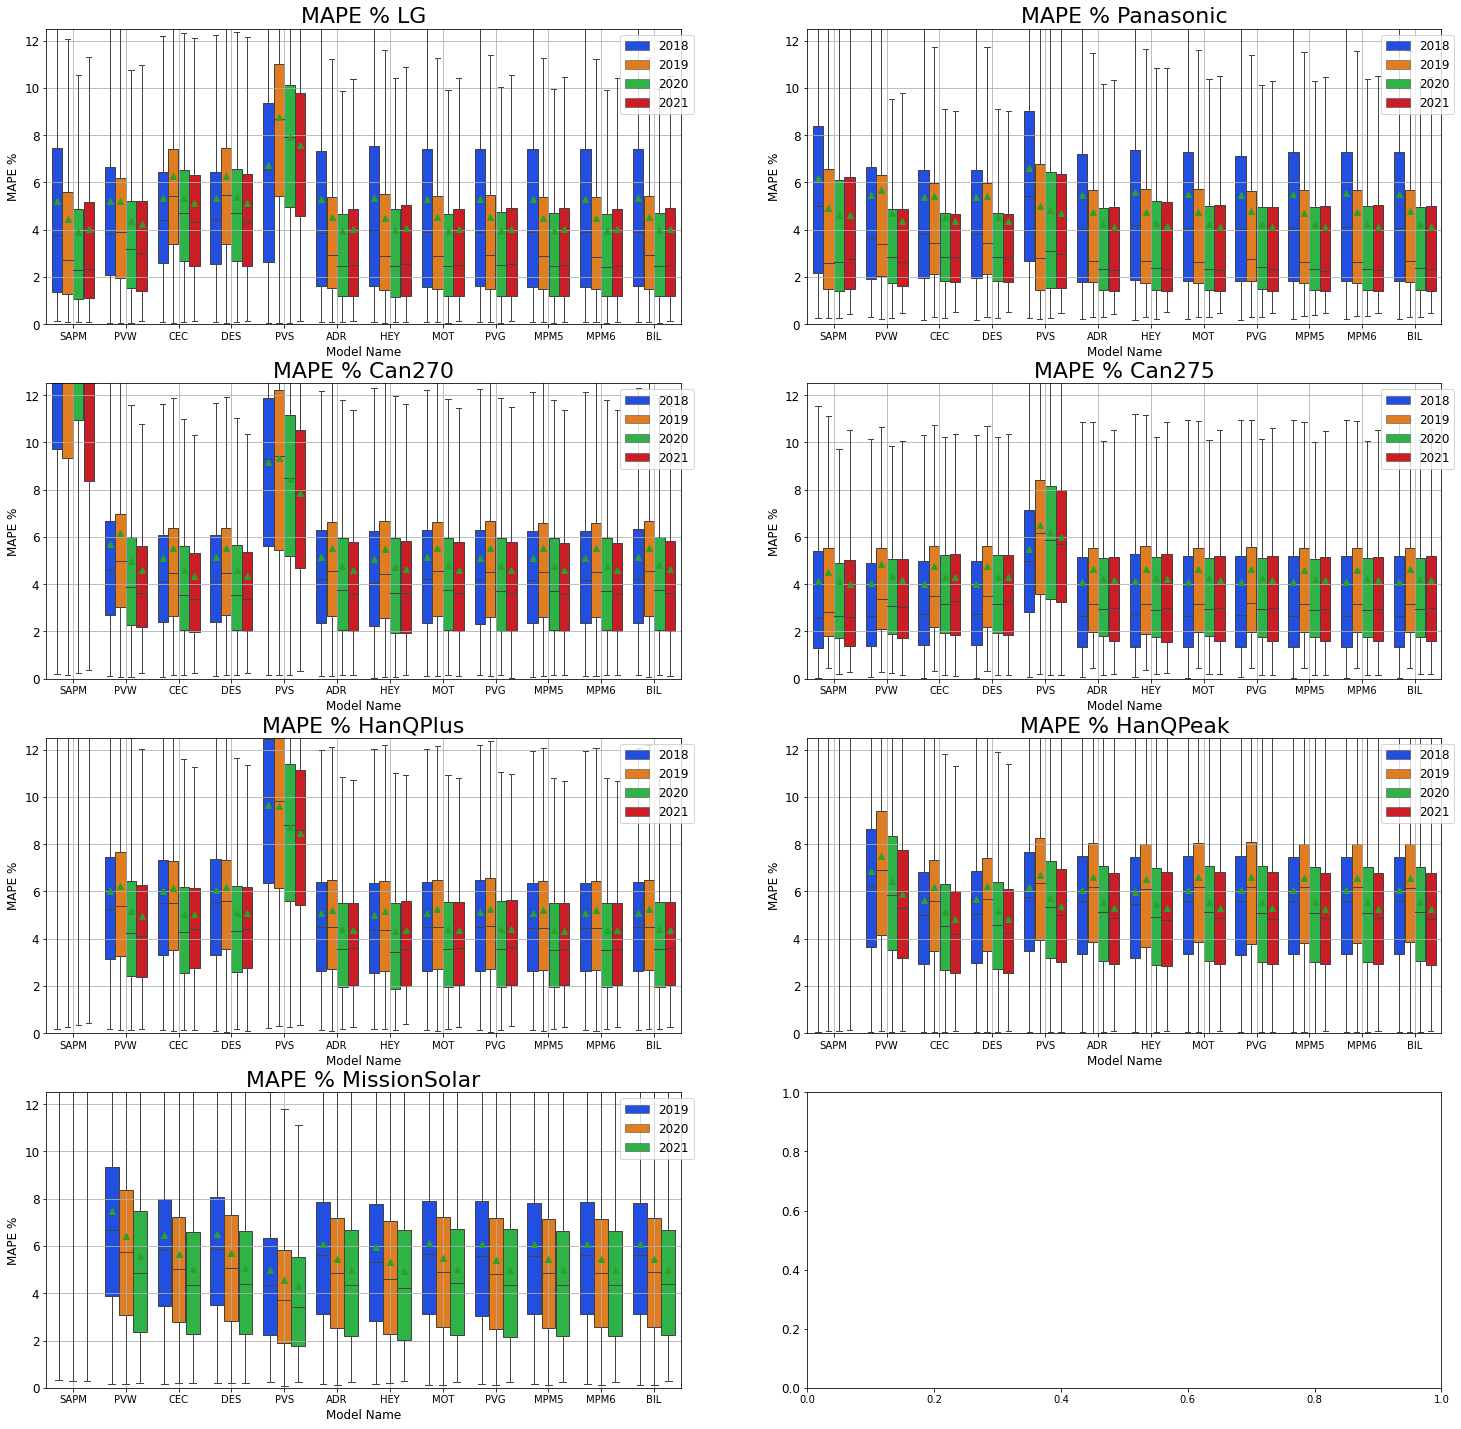

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))   
ax = sns.boxplot(x='Model Name', y='MAPE %', data = meta.loc[meta['System']=='LG'], hue='Year', showmeans=True,ax = axes[0,0], showfliers=False,palette='bright')
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.03, 1), loc='upper right')
ax.set_title('MAPE % LG')
ax = sns.boxplot(x='Model Name', y='MAPE %', data = meta.loc[meta['System']=='Panasonic'], hue='Year', showmeans=True,ax = axes[0,1], showfliers=False,palette='bright')
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.03, 1), loc='upper right')
ax.set_title('MAPE % Panasonic')   
ax = sns.boxplot(x='Model Name', y='MAPE %', data = meta.loc[meta['System']=='Can270'], hue='Year', showmeans=True,ax = axes[1,0], showfliers=False,palette='bright')
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.03, 1), loc='upper right')
ax.set_title('MAPE % Can270')   
ax = sns.boxplot(x='Model Name', y='MAPE %', data = meta.loc[meta['System']=='Can275'], hue='Year', showmeans=True,ax = axes[1,1], showfliers=False,palette='bright')
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.03, 1), loc='upper right')
ax.set_title('MAPE % Can275') 
ax = sns.boxplot(x='Model Name', y='MAPE %', data = meta.loc[meta['System']=='HanQPlus'], hue='Year', showmeans=True,ax = axes[2,0], showfliers=False,palette='bright')
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.03, 1), loc='upper right')
ax.set_title('MAPE % HanQPlus')  
ax = sns.boxplot(x='Model Name', y='MAPE %', data = meta.loc[meta['System']=='HanQPeak'], hue='Year', showmeans=True,ax = axes[2,1], showfliers=False,palette='bright')
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.03, 1), loc='upper right')
ax.set_title('MAPE % HanQPeak')  
ax = sns.boxplot(x='Model Name', y='MAPE %', data = meta.loc[meta['System']=='MissionSolar'], hue='Year', showmeans=True,ax = axes[3,0], showfliers=False,palette='bright')
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.03, 1), loc='upper right')
ax.set_title('MAPE % MissionSolar')                         

Text(0.5, 1.0, 'MBE 2021')

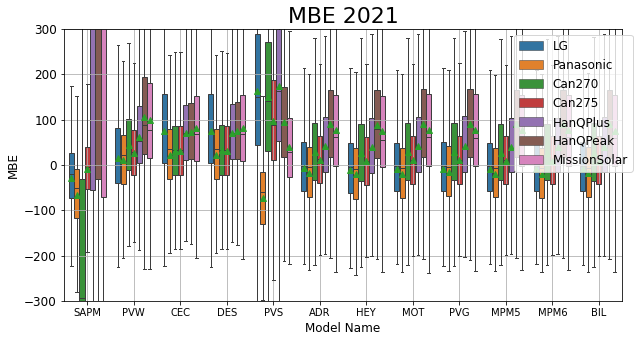

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = sns.boxplot(x='Model Name', y='MBE', data = meta.loc[meta['Year']==2021], hue='System', showmeans=True, showfliers=False)
ax.set_ylim([-300,300])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.03, 1), loc='upper right')
ax.set_title('MBE 2021')